# Keras is Kewl
The Consumer Complaint Database is a collection of complaints about consumer financial products and services. The database generally updates daily.
Download the dataset [here](https://catalog.data.gov/dataset/consumer-complaint-database)

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

Using TensorFlow backend.


## Read in and preview our data
pandas read_csv method allows us to specify *nrows* to limit our dataset - useful when the dataset is massive and your processor aint winning any awards

In [2]:
df = pd.read_csv('complaints.csv', encoding='latin-1', nrows=20000)
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
2,2019-10-25,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I would like to request the suppression of the...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,937XX,NaN,Consent provided,Web,2019-10-25,Closed with explanation,Yes,NaN,3417821
3,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
4,2019-02-08,Vehicle loan or lease,Lease,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,HYUNDAI CAPITAL AMERICA,FL,33161,NaN,Consent not provided,Web,2019-02-08,Closed with non-monetary relief,Yes,NaN,3146310


## Remove unrequired features and null observations
When a data scientist says *variable* or *feature*, they are just using a fancy word for **column**.  
Similarly, when they say *record* or *observation*, they are just using a fancy word for **row**

In [3]:
col = ['Consumer complaint narrative', 'Product', 'Date received']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.head()

,Consumer complaint narrative,Product,Date received
0,transworld systems inc. \nis trying to collect...,Debt collection,2019-09-24
2,I would like to request the suppression of the...,"Credit reporting, credit repair services, or o...",2019-10-25
3,"Over the past 2 weeks, I have been receiving e...",Debt collection,2019-11-08
6,I was unable to request a security freeze with...,"Credit reporting, credit repair services, or o...",2019-12-19
10,"I was sold access to an event digitally, of wh...","Money transfer, virtual currency, or money ser...",2019-09-08


In [4]:
product_counts = df['Product'].value_counts()
product_counts

Credit reporting, credit repair services, or other personal consumer reports    2054
Debt collection                                                                  878
Credit card or prepaid card                                                      450
Mortgage                                                                         404
Checking or savings account                                                      295
Student loan                                                                     164
Vehicle loan or lease                                                            104
Money transfer, virtual currency, or money service                                94
Payday loan, title loan, or personal loan                                         90
Consumer Loan                                                                      4
Payday loan                                                                        3
Credit card                                                      

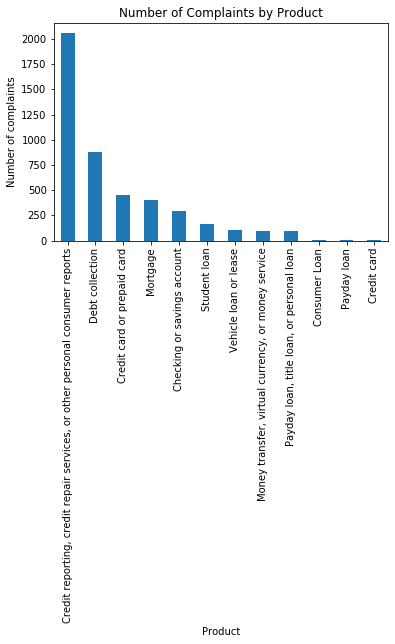

In [5]:
fig, ax = plt.subplots()
product_counts.plot.bar();
plt.title("Number of Complaints by Product")
plt.ylabel("Number of complaints")
plt.xlabel("Product")
plt.show()

In [6]:
# Split data into train and test
train_size = int(len(df) * .8)
test_size = (len(df) - train_size)
print ("Train size: %d" % train_size)
print ("Test size: %d" % test_size)

Train size: 3633
Test size: 909


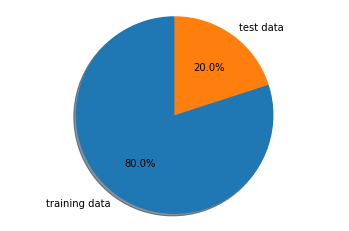

In [7]:
fig1, ax1 = plt.subplots()
labels = "training data","test data"
sizes = [train_size, test_size]
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Split the data into train and test data sets
- python tip: 
 - array[:n] means from the beginning to position n (excluded)
 - array[n:] means from position n (included) to the end

In [8]:
train_narrative = df['Consumer complaint narrative'][:train_size]
train_product = df['Product'][:train_size]

test_narrative = df['Consumer complaint narrative'][train_size:]
test_product = df['Product'][train_size:]

## Tokenize based on tf-idf
tf–idf (term frequency–inverse document frequency), is a numerical statistic that is intended to reflect how important a word is to a document. The tf–idf value increases proportionally to the number of times a word appears in the document, with multiple documents the tf-idf value is offset by the number of documents in the corpus (document collection) that contain the word, this helps us adjust for the fact that some words appear more frequently in general. For example, in a collection of papers about biology, the word science may appear important in one document, but when we realise it is just as common in every other document, it suddenly becomes less significant.

The  Tokenizer class allows to vectorize a text dataset, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

- num_words: the maximum number of words to keep, based on word frequency (n-1)
- char_level: if True, every character will be treated as a token.

In [9]:
max_words = 1001
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

fit_on_texts updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency.

In [10]:
tokenize.fit_on_texts(train_narrative) # only fit on train
x_train = tokenize.texts_to_matrix(train_narrative)
x_test = tokenize.texts_to_matrix(test_narrative)

### Use sklearn utility to convert label strings to numbered index
We don't want to fit our encoder to the test data, we want to fit it to the train data and then transform both the train and test data, the train data should therefore be a perfect fit

fit() : used for generating learning model parameters from training data
transform() : parameters generated from fit() method,applied upon model to generate transformed data set.

In [11]:
encoder = LabelEncoder()
encoder.fit(train_product)
y_train = encoder.transform(train_product)
y_test = encoder.transform(test_product)

### one hot encode the data
np.utils.to_categorical is used to convert array of labeled data(from 0 to nb_classes-1) to one-hot vector.  

For example an array having 3 classes, Y = {4, 8, 9, 4, 9}  

to_categorical(Y) will output 

[  
    [0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0. ],  
    [0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0. ],  
    [0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1. ],  
    [0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0. ],  
    [0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1. ]  
]

In [12]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [13]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (3633, 1001)
x_test shape: (909, 1001)
y_train shape: (3633, 12)
y_test shape: (909, 12)


## Build the model

For some background on relu, softmax and sigmoid read more about [activation functions](https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e)  

The model used in this example is a sequential model, see the [keras guide to the sequential model](https://keras.io/getting-started/sequential-model-guide/) for more details. Think of the sequential model as your textbook neural network, a linear stack of layers, each layer applying bias and executing activation functions etc. 

Dense Layer:

A dense layer represents a matrix vector multiplication. (assuming your batch size is 1) The values in the matrix are the trainable parameters which get updated during backpropagation.
So you get a m dimensional vector as output. A dense layer thus is used to change the dimensions of your vector. Mathematically speaking, it applies a rotation, scaling, translation transform to your vector.

Dropout Layer:

A dropout layer is used for regularization where you randomly set some of the dimensions of your input vector to be zero with probability 𝑘𝑒𝑒𝑝_𝑝𝑟𝑜𝑏. A dropout layer does not have any trainable parameters i.e. nothing gets updated during backward pass of backpropagation.

Batch size and epochs:

For a more thorough explanation of the batch size and epochs hyperparameters see [here](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/) but basically the batch size is a number of samples processed before the model is updated. The number of epochs is the number of complete passes through the training dataset. The size of a batch must be more than or equal to one and less than or equal to the number of samples in the training dataset



In [14]:
batch_size = 32
epochs = 5

In [15]:
# Build the model
model = Sequential()
# the shape of the model needs to be explicit in the first layer only, later layers can infer the shape
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
# As it is a multi-class problem, you have to use the categorical_crossentropy, the binary cross entropy will produce strange results, and most likely only evaluate the first two classes only.
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## time to fit the model
validation_split: Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. The validation data is selected from the last samples in the x and y data provided, before shuffling.

You actually would not want to resample your validation set after each epoch. If you did this your model would be trained on every single sample in your dataset and thus this will cause overfitting. You want to always split your data before the training process and then the algorithm should only be trained using the subset of the data for training.

The function as it is designed ensures that the data is separated in such a way that it always trains on the same portion of the data for each epoch. All shuffling is done within the training sample between epochs if that option is chosen.

In this instance the data split as it stands is fine, however for some datasets getting the last few instances is not useful, specifically if the dataset is regroup based on class. Then the distribution of your classes will be skewed. Thus you will need some kind of random way to extract a subset of the data to get balanced class distributions in the training and validation set. For this I always like to use the sklearn function as follows

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.33, shuffle= True)

In [16]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 3269 samples, validate on 364 samples
Epoch 1/5
3269/3269 [==============================] - 1s 282us/step - loss: 1.2689 - accuracy: 0.6057 - val_loss: 0.8430 - val_accuracy: 0.7445
Epoch 2/5
3269/3269 [==============================] - 1s 214us/step - loss: 0.6379 - accuracy: 0.7954 - val_loss: 0.7078 - val_accuracy: 0.7885
Epoch 3/5
3269/3269 [==============================] - 1s 210us/step - loss: 0.4511 - accuracy: 0.8599 - val_loss: 0.6784 - val_accuracy: 0.7885
Epoch 4/5
3269/3269 [==============================] - 1s 212us/step - loss: 0.3105 - accuracy: 0.9156 - val_loss: 0.6528 - val_accuracy: 0.8077
Epoch 5/5
3269/3269 [==============================] - 1s 211us/step - loss: 0.2109 - accuracy: 0.9483 - val_loss: 0.6864 - val_accuracy: 0.7885


In [17]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

909/909 [==============================] - 0s 35us/step
Test score: 0.7813032040632728
Test accuracy: 0.7590758800506592


In [18]:
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_narrative.iloc[i][:50], "...")
    print('Actual label:' + test_product.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

Onemain financial took an additional payment of, { ...
Actual label:Payday loan, title loan, or personal loan
Predicted label: Checking or savings account

I sent a certified letter with dispute attached al ...
Actual label:Credit reporting, credit repair services, or other personal consumer reports
Predicted label: Credit reporting, credit repair services, or other personal consumer reports

I have faithfully been making payments on time sin ...
Actual label:Student loan
Predicted label: Student loan

XX/XX/19 Never authorized an inquiry for credit wi ...
Actual label:Credit reporting, credit repair services, or other personal consumer reports
Predicted label: Credit reporting, credit repair services, or other personal consumer reports

I recently received a response to a dispute ( see  ...
Actual label:Debt collection
Predicted label: Credit reporting, credit repair services, or other personal consumer reports

Citizens Bank ( Citizens Bank is a brand name of C ...
Actual label:Check